<a href="https://colab.research.google.com/github/heroza/Skin-Cancer-Diagnosis/blob/main/Skin_Cancer_Diagnosis_using_ISIC_2018_Dataset_OversamplingOnFeatureMaps_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Library, atribut, and function

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
from pathlib import Path
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score, confusion_matrix, accuracy_score
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model, load_model
from keras.utils.np_utils import to_categorical

!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# input image size
IMAGE_W = 224
IMAGE_H = 224
IMG_SIZE = (IMAGE_W,IMAGE_H)
num_classes = 7
EPOCHS = 300
BATCH_SIZE = 64
opt_adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
opt_SGD = SGD(learning_rate=0.001)
the_arch = 'resnet50'

#Data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

#Callbacks
best_model_fpath = '/content/drive/MyDrive/PHD/Model/best_model_no.h5'
last_model_fpath = '/content/drive/MyDrive/PHD/Model/last_model_no.h5'
mc = ModelCheckpoint(best_model_fpath, monitor='val_balanced_acc', mode='max', verbose=1, save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_balanced_acc', patience=50, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=50,monitor='val_balanced_acc')


In [ ]:
# load train and test dataset
def preprocess_image_input(input_images, arch = the_arch):
  input_images = input_images.astype('float32')
  if arch == 'inception_v3':
    output_ims = tf.keras.applications.inception_v3.preprocess_input(input_images)
  else:
    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

def load_cifar10_dataset():
  from keras.datasets import cifar10
    # load dataset
  (X_train, y_train), (X_val, y_val) = cifar10.load_data()
    # one hot encode target values
  y_train = to_categorical(y_train)
  y_val = to_categorical(y_val)

  return X_train, y_train, X_val, y_val

def balanced_acc(y_true, y_pred):
    from keras import backend as K

    tensor1 = tf.math.argmax(y_true, axis=1)
    tensor2 = tf.math.argmax(y_pred, axis=1)

    cm = tf.math.confusion_matrix(tensor1, tensor2)
    
    diag = tf.linalg.tensor_diag_part (cm)
    tpfn = tf.cast(K.sum(cm, axis = 1), tf.float32) + K.epsilon()
    recall = tf.divide(tf.cast(diag, tf.float32),tpfn)
    balanced_acc = K.mean(recall)
    return balanced_acc

def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def define_base_model(arch = the_arch):
  if arch == 'dense':
    input_tensor = Input(shape=(2048))
  else:
    input_tensor = Input(shape=(IMAGE_H, IMAGE_W, 3))
  #x = UpSampling2D(size=(7,7))(input_tensor)
  #x = data_augmentation(input_tensor)
  #x = layers.Rescaling(1.0 / 255)(input_tensor)  # Rescale inputs
  if arch == 'resnet50':
    x = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)(input_tensor, training=False)
    x = GlobalAveragePooling2D()(x)
  elif arch == 'inception_v3':
    x = InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)(input_tensor, training=False)
    x = GlobalAveragePooling2D()(x)
  else:
    x = input_tensor
  #x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(512, activation='relu')(x)
  predictions = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=input_tensor, outputs=predictions)
  model.compile(optimizer = opt_SGD , loss = "categorical_crossentropy", metrics=['accuracy', balanced_acc])
  return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.close()
 
# scale pixels
def norm_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

def load_isic2018_dataset(train_under_frac = 0):
  df_train = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv') 
  df_val = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv') 

  #decode one hot label
  df_train["Labels"] = (df_train.iloc[:, 1:]).idxmax(axis=1)
  df_val["Labels"] = (df_val.iloc[:, 1:]).idxmax(axis=1)

  #random undersampling for training dataset
  if train_under_frac !=0:
    df_train = df_train.drop(df_train[df_train['Labels'] == 'NV'].sample(frac=train_under_frac).index)

  #drop one-hot column
  df_train = df_train.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])
  df_val = df_val.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])

  #make filepaths of the image
  dir_train = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_Input/'
  dir_val = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_Input/'
  df_train['FilePaths'] = dir_train + df_train['image'] + '.jpg'
  df_val['FilePaths'] = dir_val + df_val['image'] + '.jpg'
  
  #load image pixels to dataframe
  df_train['image_px'] = df_train['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))
  df_val['image_px'] = df_val['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))

  X_train = np.asarray(df_train['image_px'].tolist())
  X_val = np.asarray(df_val['image_px'].tolist())
  y_train = np.array(df_train['Labels'].values)
  y_val = np.array(df_val['Labels'].values)

  label_encoder = preprocessing.LabelEncoder()
  y_train = label_encoder.fit_transform(y_train)
  y_val = label_encoder.fit_transform(y_val)
  
  y_train = to_categorical(y_train, num_classes = num_classes)
  y_val = to_categorical(y_val, num_classes = num_classes)

  return X_train, y_train, X_val, y_val, df_train, df_val

def reset_dataset(df_train, df_val):
  X_train = np.asarray(df_train['image_px'].tolist())
  X_val = np.asarray(df_val['image_px'].tolist())
  y_train = np.array(df_train['Labels'].values)
  y_val = np.array(df_val['Labels'].values)

  X_train = preprocess_image_input(X_train, the_arch)
  X_val = preprocess_image_input(X_val, the_arch)

  label_encoder = preprocessing.LabelEncoder()
  y_train = label_encoder.fit_transform(y_train)
  y_val = label_encoder.fit_transform(y_val)
  
  y_train = to_categorical(y_train, num_classes = num_classes)
  y_val = to_categorical(y_val, num_classes = num_classes)
  return X_train, y_train, X_val, y_val

def SMOTE_Data(X, y, one_hot = False, k = 5):
  if one_hot:
    y = np.argmax(y, axis=1)
  sm = SMOTE(random_state=42, k_neighbors=k)
  X_resampled, y_resampled = sm.fit_resample(X.reshape((-1, IMAGE_W * IMAGE_H * 3)), y)
  X_resampled = X_resampled.reshape(-1, IMAGE_W, IMAGE_H, 3)
  if one_hot:
    y_resampled = to_categorical(y_resampled, num_classes = num_classes)
  else:
    y_resampled = y_resampled.reshape(-1,1)
  return X_resampled, y_resampled

def SMOTE_Data2(X, y, one_hot = False, k = 5):
  if one_hot:
    y = np.argmax(y, axis=1)
  sm = SMOTE(random_state=42, k_neighbors=k)
  X_resampled, y_resampled = sm.fit_resample(X, y)
  if one_hot:
    y_resampled = to_categorical(y_resampled, num_classes = num_classes)
  else:
    y_resampled = y_resampled.reshape(-1,1)
  return X_resampled, y_resampled

#Exp

In [ ]:
input_tensor = Input(shape=(IMAGE_H, IMAGE_W, 3))
x = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)(input_tensor, training=False)
x = GlobalAveragePooling2D()(x)
res50 = Model(inputs=input_tensor, outputs=x)

In [ ]:
X_train = res50.predict(X_train)
X_val = res50.predict(X_val)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

(5321, 2048)
(5321, 7)
(193, 2048)
(193, 7)
Counter train data:  Counter({5: 2011, 4: 1113, 2: 1099, 1: 514, 0: 327, 6: 142, 3: 115})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


In [ ]:
X_train, y_train = SMOTE_Data2(X_train, y_train, True)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

(14077, 2048)
(14077, 7)
(193, 2048)
(193, 7)
Counter train data:  Counter({5: 2011, 4: 2011, 2: 2011, 3: 2011, 0: 2011, 1: 2011, 6: 2011})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


# Main

In [ ]:
X_train, y_train, X_val, y_val = load_cifar10_dataset()

In [ ]:
#load data
X_train, y_train, X_val, y_val, df_train, df_val = load_isic2018_dataset(train_under_frac = 0.7)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(5321, 224, 224, 3)
(5321, 7)
(193, 224, 224, 3)
(193, 7)


In [ ]:
X_train = preprocess_image_input(X_train, the_arch)
X_val = preprocess_image_input(X_val, the_arch)

In [ ]:
X_train, y_train = SMOTE_Data(X_train, y_train, True)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

(14077, 2048)
(14077, 7)
(193, 224, 224, 3)
(193, 7)
Counter train data:  Counter({5: 2011, 4: 2011, 2: 2011, 3: 2011, 0: 2011, 1: 2011, 6: 2011})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


In [ ]:
#USe TF.data
#training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

#autotune = tf.data.AUTOTUNE
#train_data_batches = training_data.shuffle(buffer_size=40000).batch(BATCH_SIZE).prefetch(buffer_size=autotune)
#valid_data_batches = validation_data.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(buffer_size=autotune)

In [ ]:
#path = '/content/drive/MyDrive/PHD/Datasets/isic2018/'
#df1 = pd.DataFrame(X_train.reshape(X_train.shape[0],-1))
#df1['y_train'] = np.argmax(y_train, axis=1).tolist()
#df2 = pd.DataFrame(X_val.reshape(X_val.shape[0],-1))
#df2['y_val'] = np.argmax(y_val, axis=1).tolist()
#df1.to_pickle(path+"isic2018_train.pkl")
#df2.to_pickle(path+"isic2018_val.pkl")

In [ ]:
path = '/content/drive/MyDrive/PHD/Datasets/isic2018/'
df1 = pd.read_pickle(path+"isic2018_train.pkl")
X_train = df1.loc[:, df1.columns != 'y_train'].to_numpy()
X_train = X_train.reshape(-1,224,224,3)
y_train = df1.loc[:, df1.columns == 'y_train'].to_numpy()
y_train = to_categorical(y_train)

df1 = pd.read_pickle(path+"isic2018_val.pkl")
X_val = df1.loc[:, df1.columns != 'y_val'].to_numpy()
X_val = X_val.reshape(-1,224,224,3)
y_val = df1.loc[:, df1.columns == 'y_val'].to_numpy()
y_val = to_categorical(y_val)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

In [ ]:
# define model
model = define_base_model('dense')
model.summary()
hst = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), verbose=1,
                    steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])
# learning curves
summarize_diagnostics(hst)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 2048)]            0         
                                                                 
 dense_18 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 512)               524800    
                                                                 
 dense_20 (Dense)            (None, 7)                 3591      
                                                                 
Total params: 2,626,567
Trainable params: 2,626,567
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
203/219 [==========================>.

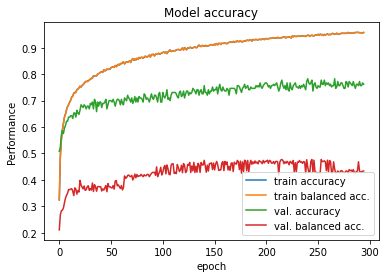

In [ ]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['balanced_acc'])
plt.plot(hst.history['val_accuracy'])
plt.plot(hst.history['val_balanced_acc'])
plt.title('Model accuracy')
plt.ylabel('Performance')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'train balanced acc.', 'val. accuracy', 'val. balanced acc.'], loc='lower right')
plt.show()

In [ ]:
#Training
#hst = model.fit(train_data_batches,
#                    epochs = EPOCHS, validation_data = valid_data_batches,      
                    #steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
#                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])


#Evaluate

In [ ]:
#save last model
model.save(last_model_fpath)

In [ ]:
last_model = load_model(last_model_fpath, custom_objects={'balanced_acc' : balanced_acc})
y_train_pred = last_model.predict(X_train)
y_val_pred = last_model.predict(X_val)

#print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on validation',accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

accuracy on training 0.973644952759821
balanced accuracy on training 0.9736449527598209
accuracy on validation 0.7616580310880829
balanced accuracy on validation 0.5643698055718961
Score on val data:  (0.55101817853241, 0.5643698055718961, 0.5497438118798837, None)


In [ ]:
best_model = load_model(best_model_fpath, custom_objects={'balanced_acc' : balanced_acc})
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on validation',accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

accuracy on training 0.9646231441358244
balanced accuracy on training 0.9646231441358244
accuracy on validation 0.7772020725388601
balanced accuracy on validation 0.7095498288006999
Score on val data:  (0.6424402018872065, 0.7095498288006999, 0.6565091345390076, None)


#Oversampling on feature map level

In [ ]:
last_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                           

In [ ]:
# summarize feature map shapes
for i in range(len(last_model.layers)):
    layer = last_model.layers[i]
    # summarize output shape
    print(i, layer.name, layer.output.shape)

0 input_5 (None, 224, 224, 3)
1 resnet50 (None, 7, 7, 2048)
2 global_average_pooling2d_2 (None, 2048)
3 flatten_2 (None, 2048)
4 dense_6 (None, 1024)
5 dense_7 (None, 512)
6 dense_8 (None, 7)


In [ ]:
# redefine model to output right after the first hidden layer
i = 2
model = Model(inputs=last_model.inputs, outputs=last_model.layers[i].output)

In [ ]:
# get feature map for first hidden layer
feature_maps = model.predict(X_train)

In [ ]:
model2 = Model(inputs=last_model.layers[i].output, outputs=last_model.layers[6].output)

In [ ]:
# get feature map for first hidden layer
feature_maps = model.predict(X_train)

#Cut-off

In [ ]:
df_train_pred = pd.DataFrame(y_train_pred, columns = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

In [ ]:
numbers = [float(x)/20 for x in range(11)]

for i in numbers:
    df_train_pred[i]= df_train_pred.MEL.map(lambda x: 1 if x > i else 0)
df_train_pred.head()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5
0,1.390465e-06,4.733610e-08,0.001533,0.000022,0.002198,0.996243,3.083446e-06,1,0,0,0,0,0,0,0,0,0,0
1,7.529122e-04,1.294077e-04,0.003562,0.000001,0.990041,0.005513,1.605807e-07,1,1,1,1,1,1,1,1,1,1,1
2,6.812071e-03,1.355026e-02,0.908789,0.015438,0.011777,0.043577,5.656496e-05,1,0,0,0,0,0,0,0,0,0,0
3,1.359046e-03,2.983967e-04,0.001583,0.000235,0.794354,0.202168,2.715136e-06,1,1,1,1,1,1,1,1,1,1,1
4,6.714983e-08,6.721391e-06,0.000430,0.000001,0.911764,0.087798,3.255211e-07,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
y_train_true= [1 if x == 4 else 0 for x in np.argmax(y_train, axis=1)]

In [ ]:
num = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
cutoff_df = pd.DataFrame( columns = ['Probability','Accuracy','Sensitivity','Specificity'])
for i in num:
    cm1 = confusion_matrix(y_train_true, df_train_pred[i])
    total1=sum(sum(cm1))
    Accuracy = (cm1[0,0]+cm1[1,1])/total1
    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,Accuracy,Sensitivity,Specificity]

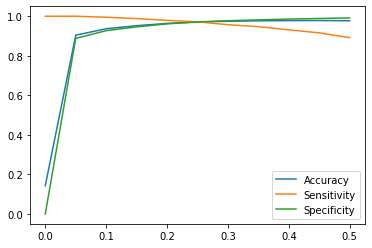

In [ ]:
cutoff_df[['Accuracy','Sensitivity','Specificity']].plot()

plt.show()

In [ ]:
i = 0.05
cm1 = confusion_matrix(y_train_true, df_train_pred[i])
total1=sum(sum(cm1))
Accuracy = (cm1[0,0]+cm1[1,1])/total1
Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])

In [ ]:
print('Accuracy: ', Accuracy)
print('Sensitivity: ', Sensitivity)
print('Specificity: ', Specificity)

Accuracy:  0.904027846842367
Sensitivity:  1.0
Specificity:  0.8880324879827615


#Confusion Metric on Validation Set

In [ ]:
#change melanoma flag back to 4
df_train_pred[df_train_pred[i] == 1] = 4
#decode one-hot y_val_pred while use cut-off melanoma data
condition = df_train_pred[i] == 4
y_train_pred2 = np.where(condition, df_train_pred[i], np.argmax(y_train_pred, axis=1))

In [ ]:
print('Accuracy: ',accuracy_score(np.argmax(y_train, axis=1), y_train_pred2))
print('Balanced accuracy: ',balanced_accuracy_score(np.argmax(y_train, axis=1), y_train_pred2))

Accuracy:  0.8957164168501811
Balanced accuracy:  0.8957164168501812


In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(np.argmax(y_train, axis=1), y_train_pred2)
print(cf_matrix)

[[1902    5    8    1   95    0    0]
 [   5 1910    5    0   91    0    0]
 [  16   14 1489    1  478   13    0]
 [   0    0    0 2011    0    0    0]
 [   0    0    0    0 2011    0    0]
 [   3   16   23    3  685 1277    4]
 [   0    0    0    0    2    0 2009]]


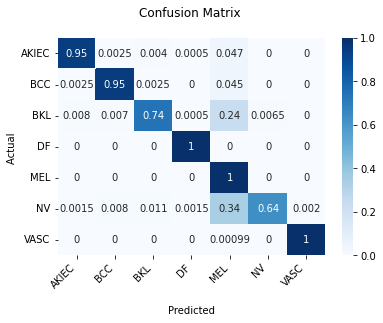

In [ ]:
ax = sns.heatmap(cf_matrix / cf_matrix.sum(axis=1, keepdims=True), annot=True, 
            cmap='Blues')

ax.set_title('Confusion Matrix \n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
ax.yaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

plt.rcParams["figure.figsize"] = (15,3)

## Display the visualization of the Confusion Matrix.
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

In [ ]:
# ordered count of rows per unique label
#labels_count = df_val['Labels'].value_counts().sort_index()

#f = plt.figure(figsize=(15, 6))
#s = sns.barplot(x=labels_count.index,y=labels_count.values)
#s.set_xticklabels(s.get_xticklabels(), rotation = 30)

#Testing

In [ ]:
dir_test = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Test_Input/'
filepaths = sorted( filter( lambda x: (os.path.isfile(os.path.join(dir_test, x))) and (x.endswith('.jpg')),
                        os.listdir(dir_test) ) )

In [ ]:
df_test = pd.DataFrame(filepaths, columns =['image'])
df_test['FilePaths'] = dir_test + df_test['image']
#df_test

In [ ]:
df_test['image_px'] = df_test['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))

In [ ]:
X_test = np.asarray(df_test['image_px'].tolist())
print(np.array(X_test).shape)

(1512, 224, 224, 3)


In [ ]:
#preprocess
X_test = preprocess_image_input(X_test)

Calculate y_pred from training and testing for analysis

In [ ]:
X_test = res50.predict(X_test)

In [ ]:
# predicting
#CHANGE THE MODEL IF NECESSARY
Y_pred2 = best_model.predict(X_test)
print("Y_pred2", Y_pred2.shape)

Y_pred2 (1512, 7)


In [ ]:
df_pred = pd.DataFrame(Y_pred2, columns = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
df_pred['image'] = df_test['FilePaths'].map(lambda x: x.replace(dir_test, '').replace('.jpg', ''))
df_pred = df_pred[['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']]
df_pred.set_index("image", inplace = True)

In [ ]:
#update MEL data using cut-off value
df_pred.MEL[df_pred.MEL > i] = 1

In [ ]:
df_pred.loc[df_pred.MEL > i, ['NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']] = 0

In [ ]:
df_pred.to_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/response_Oversampling_featuremaps.csv')

#Load ISIC 2018 Challange Data

In [ ]:
X_train, y_train, X_val, y_val = load_isic2018_dataset(train_under_frac = 0.7)

[Text(0, 0, 'DF'),
 Text(0, 0, 'VASC'),
 Text(0, 0, 'AKIEC'),
 Text(0, 0, 'BCC'),
 Text(0, 0, 'BKL'),
 Text(0, 0, 'MEL'),
 Text(0, 0, 'NV')]

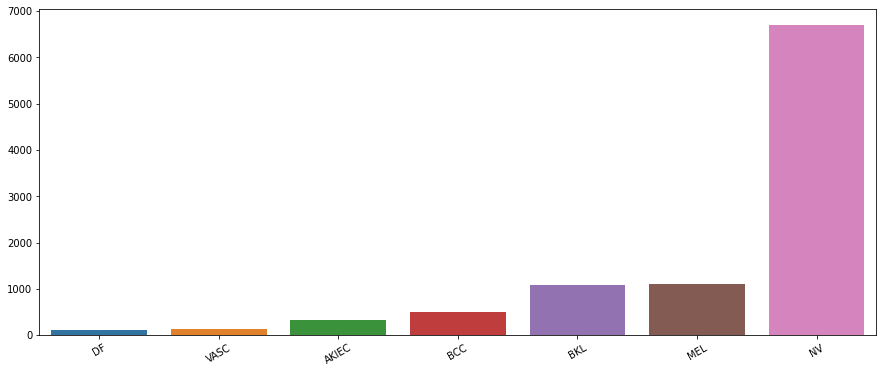

In [ ]:
# ordered count of rows per unique label
labels_count = y_train.value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

In [ ]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(y_train == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
#labels = sorted(df_train['Labels'].unique())
#for label in range(7):
#    plot_images_per_label(y_train, 3, (12,9))

Drop duplicate images

In [ ]:
#df_group = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_LesionGroupings.csv') 
#df_train = df_train.set_index('image').join(df_group.set_index('image'))
#df_train = df_train.drop_duplicates(subset=['lesion_id'])

#DeepSMOTE Oversampling

In [ ]:
from numpy import moveaxis
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn as nn

max_el = np.inf

args = {}
args['dim_h'] = 64         # factor controlling size of hidden layers
args['n_channel'] = 3#1    # number of channels in the input data 
args['n_z'] = 600 #300     # number of dimensions in latent space. 
args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.0002        # learning rate for Adam optimizer .000
args['epochs'] = 300       # how many epochs to run for
args['batch_size'] = 100   # batch size for SGD
args['save'] = True        # save weights at each epoch of training if True
args['train'] = True       # train networks if True, else load networks from
args['patience'] = 20

In [ ]:
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        # [(W−K+2P)/S]+1
        self.conv = nn.Sequential(
            nn.AvgPool2d(7, stride=7),
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),# 16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False), # 8
            nn.BatchNorm2d(self.dim_h * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),# 4
            nn.BatchNorm2d(self.dim_h * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 0, bias=False),#14
            nn.BatchNorm2d(self.dim_h * 8),
            nn.LeakyReLU(0.2, inplace=True))
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        
        x = x.squeeze()
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 2**3 * 7 * 7),
            nn.ReLU())

        # deconvolutional filters, essentially inverse of convolutional filters
        # H_out ​= (H_in​−1)*stride[0] − 2×padding[0] + dilation[0]×(kernel_size[0]−1) + output_padding[0] + 1
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4), #10
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4), #13
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, self.dim_h, 4),# 16
            nn.BatchNorm2d(self.dim_h),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h, 3, 4, 2, 1),# 32
            nn.UpsamplingBilinear2d(scale_factor=7),
            nn.Tanh())

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 2**3, 7, 7)
        x = self.deconv(x)
        return x

##############################################################################
"""set models, loss functions"""
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

def biased_get_class(X, y, c):
    
    xbeg = X[y == c]
    ybeg = y[y == c]
    
    return xbeg, ybeg
    #return xclass, yclass

def G_SM(X, y,n_to_sample,cl):
    n_neigh = 5
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)

    # generating samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]

    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)

    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

def DeepSMOTE_train(X_train, y_train, one_hot = False):
  from torch.utils.data import TensorDataset
  import os

  max_el = np.max(X_train)
  X_train = X_train / max_el
  X_train = moveaxis(X_train, 3, 1)
  if one_hot:
    y_train = np.argmax(y_train, axis=1)
  #X_train = X_train.astype('float32') / 255.
  
  batch_size = args['batch_size']
  patience = args['patience']
  encoder = Encoder(args)
  decoder = Decoder(args)

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print(device)
  decoder = decoder.to(device)
  encoder = encoder.to(device)

  train_on_gpu = torch.cuda.is_available()

  #decoder loss function
  criterion = nn.MSELoss()
  criterion = criterion.to(device)

  num_workers = 0

  #torch.Tensor returns float so if want long then use torch.tensor
  tensor_x = torch.from_numpy(X_train.copy())#torch.Tensor(X_train)
  tensor_y = torch.tensor(y_train,dtype=torch.long)
  mnist_bal = TensorDataset(tensor_x,tensor_y) 
  train_loader = torch.utils.data.DataLoader(mnist_bal, 
      batch_size=batch_size,shuffle=True,num_workers=num_workers)

  best_loss = np.inf

  enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
  dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

  for epoch in range(args['epochs']):
      train_loss = 0.0
      tmse_loss = 0.0
      tdiscr_loss = 0.0
      # train for one epoch -- set nets to train mode
      encoder.train()
      decoder.train()
  
      for images,labs in train_loader:
      
          # zero gradients for each batch
          encoder.zero_grad()
          decoder.zero_grad()
          images, labs = images.to(device), labs.to(device)
          labsn = labs.detach().cpu().numpy()
#            print('images shape', images.shape)
          # run images
          z_hat = encoder(images)
#            print('images shape after encoding', z_hat.shape)
      
          x_hat = decoder(z_hat) #decoder outputs tanh
#            print('images shape after decoding', x_hat.shape)
          mse = criterion(x_hat,images)
                  
          resx = []
          resy = []
      
          tc = np.random.choice(num_classes,1)
          #tc = 9
          xbeg = X_train[y_train == tc]
          ybeg = y_train[y_train == tc] 
          xlen = len(xbeg)
          nsamp = min(xlen, 100)
          ind = np.random.choice(list(range(len(xbeg))),nsamp,replace=False)
          xclass = xbeg[ind]
          yclass = ybeg[ind]
      
          xclen = len(xclass)
          xcminus = np.arange(1,xclen)
          
          xcplus = np.append(xcminus,0)
          xcnew = (xclass[[xcplus],:])
          xcnew = xcnew.reshape(xcnew.shape[1],xcnew.shape[2],xcnew.shape[3],xcnew.shape[4])
      
          xcnew = torch.Tensor(xcnew)
          xcnew = xcnew.to(device)
      
          #encode xclass to feature space
          xclass = torch.Tensor(xclass)
          xclass = xclass.to(device)
          xclass = encoder(xclass)
      
          xclass = xclass.detach().cpu().numpy()
      
          xc_enc = (xclass[[xcplus],:])
          xc_enc = np.squeeze(xc_enc)
      
          xc_enc = torch.Tensor(xc_enc)
          xc_enc = xc_enc.to(device)
          
          ximg = decoder(xc_enc)
          
          mse2 = criterion(ximg,xcnew)
      
          comb_loss = mse2 + mse
          comb_loss.backward()
      
          enc_optim.step()
          dec_optim.step()
      
          train_loss += comb_loss.item()*images.size(0)
          tmse_loss += mse.item()*images.size(0)
          tdiscr_loss += mse2.item()*images.size(0)

      train_loss = train_loss/len(train_loader)
      tmse_loss = tmse_loss/len(train_loader)
      tdiscr_loss = tdiscr_loss/len(train_loader)
      print('Epoch: {} \tTrain Loss: {:.6f} \tmse loss: {:.6f} \tmse2 loss: {:.6f}'.format(epoch,
              train_loss,tmse_loss,tdiscr_loss))
      
  
  
      #store the best encoder and decoder models
      #here, /crs5 is a reference to 5 way cross validation, but is not
      #necessary for illustration purposes
      if train_loss < best_loss:
          print('Saving..')
          patience = args['patience']
          path_enc = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/32/bst_enc.pth'
          path_dec = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/32/bst_dec.pth'
        
          torch.save(encoder.state_dict(), path_enc)
          torch.save(decoder.state_dict(), path_dec)
  
          best_loss = train_loss
      else:
          patience = patience - 1

      if patience == 0:
          print('Out of patience. \n')
          break

def DeepSMOTE_Data(X_train, y_train, one_hot = False):
  batch_size = args['batch_size']
  max_el = np.max(X_train)
  X_train = X_train / max_el
  X_train = moveaxis(X_train, 3, 1)
  if one_hot:
    y_train = np.argmax(y_train, axis=1)
  #Generate artificial images
  import torch
  np.printoptions(precision=5,suppress=True)

  #path on the computer where the models are stored
  modpth = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/32/'

  path_enc = modpth + '/bst_enc.pth'
  path_dec = modpth + '/bst_dec.pth'
  
  train_on_gpu = torch.cuda.is_available()
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  encoder = Encoder(args)
  encoder.load_state_dict(torch.load(path_enc), strict=False)
  encoder = encoder.to(device)

  decoder = Decoder(args)
  decoder.load_state_dict(torch.load(path_dec), strict=False)
  decoder = decoder.to(device)

  encoder.eval()
  decoder.eval()

  resx = []
  resy = []
  
  counter = Counter(y_train)
  counter = sorted(counter.items())
  counter = [value for _, value in counter]

  for i in range(num_classes):
      torch.cuda.empty_cache()

      xclass, yclass = biased_get_class(X_train, y_train, i)
      #encode xclass to feature space
      xclass = torch.Tensor(xclass)
      xclass = xclass.to(device)
      xclass = encoder(xclass)
          
      xclass = xclass.detach().cpu().numpy()
      n = np.max(counter) - counter[i]
      if n == 0:
        continue
#        resx2 = []
#        resy2 = []
#        for j in range(batch_size, n+batch_size+1, batch_size):
#          if j <= n:
#            batch_size_max = batch_size
#          elif n % batch_size != 0:
#            batch_size_max = n%batch_size
#          else:
#            break
#          xsamp, ysamp = G_SM(xclass,yclass,batch_size_max,i)
      xsamp, ysamp = G_SM(xclass,yclass,n,i)
      ysamp = np.array(ysamp)
  
      """to generate samples for resnet"""   
      xsamp = torch.Tensor(xsamp)
      xsamp = xsamp.to(device)
      ximg = decoder(xsamp)

      ximn = ximg.detach().cpu().numpy()
#        resx2.append(ximn)
#        resy2.append(ysamp)
#        
#        resx2 = np.vstack(resx2)
#        resy2 = np.hstack(resy2)
      resx.append(ximn)
      resy.append(ysamp)
  
  resx1 = np.vstack(resx)
  resy1 = np.hstack(resy)
  resx1 = resx1.reshape(resx1.shape[0],-1)
  X_train = X_train.reshape(X_train.shape[0],-1)
  X_train = np.vstack((resx1,X_train))
  y_train = np.hstack((resy1,y_train))
  y_train = to_categorical(y_train)
  X_train = X_train.reshape(-1, 3, IMAGE_W, IMAGE_H)
  X_train = moveaxis(X_train, 1, 3)
  X_train = X_train * max_el
  return X_train, y_train

#Split dataset to train and val

In [ ]:
# stratified train and rem (20%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=1)

print('Train Data: ', X_train.shape)
print('Remaining Data: ', X_val.shape)

Train Data:  (11261, 224, 224, 3)
Remaining Data:  (2816, 224, 224, 3)


In [ ]:
#Data Augmentation
dataaugment = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

dataaugment.fit(X_train)

#Fine Tune

In [ ]:
limit = 171
for layer in model.layers[:limit]:
   layer.trainable = False
for layer in model.layers[limit:]:
   layer.trainable = True

optimizer_SGD = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer = optimizer_SGD , loss = "categorical_crossentropy", metrics=['accuracy', balanced_acc])
hst2 = model.fit(train_data_batches,
                    epochs = EPOCHS, validation_data = valid_data_batches,
                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])


In [ ]:
# summarize history for accuracy
plt.plot(hst2.history['balanced_acc'])
plt.plot(hst2.history['val_balanced_acc'])
plt.title('model balance_acc after tunning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()